# Compare a few ways to generate synthetic forecasts

In [1]:
%cd /g/data/xv83/users/ds0092/active_projects/Squire_2022_correlation/notebooks/exploratory

/g/data/xv83/users/ds0092/active_projects/Squire_2022_correlation/notebooks/exploratory


In [2]:
import xarray as xr

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import cartopy.crs as ccrs

from src import data, utils, stats, ar_model

import warnings

warnings.filterwarnings("ignore")

In [3]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [4]:
DATA_DIR = "../../data/processed/"

# Load some SST data to play with

In [5]:
def prep_data(ds, hindcast=False):
    """
    Some steps to prepare some data. If processing a hindcast, set
    hindcast=True
    """

    if hindcast:
        coarsen_dim = "lead"
        mean_dim = "init"
    else:
        coarsen_dim = mean_dim = "time"

    # In case time is a dask array
    ds = ds.assign_coords({"time": ds.time.compute()})

    # Annual
    ds = utils.get_consecutive_month_avg(ds, range(1, 13), time_dim=coarsen_dim)

    # 5x5 deg grid
    ds = data.interpolate_to_regular_grid(ds.chunk({"lat": -1, "lon": -1}), 5)

    # Anomalies
    ds = ds - ds.mean(mean_dim)

    # Detrend
    ds = utils.detrend(ds, dim=mean_dim)

    return ds.compute()

#### Reanalysis data: HadISST

In [172]:
ds = prep_data(xr.open_zarr(f"{DATA_DIR}/tos_HadISST.zarr", use_cftime=True))
reanalysis = ds.assign_coords({"time": ds.time.dt.year}).rename({"sst": "tos"})

In [173]:
ds

<xarray.Dataset>
Dimensions:  (time: 152, lon: 72, lat: 36)
Coordinates:
  * time     (time) object 1870-12-16 12:00:00 ... 2021-12-16 12:00:00
  * lon      (lon) float64 2.5 7.5 12.5 17.5 22.5 ... 342.5 347.5 352.5 357.5
  * lat      (lat) float64 -87.5 -82.5 -77.5 -72.5 -67.5 ... 72.5 77.5 82.5 87.5
    area     (lat, lon) float64 1.346e+10 1.346e+10 ... 1.346e+10 1.346e+10
Data variables:
    sst      (time, lat, lon) float64 nan nan nan ... -0.0005719 -0.000744

#### CMIP6 historical run: HadGEM3-GC31-MM

In [159]:
model = "HadGEM3-GC31-MM"

ds = prep_data(
    xr.open_zarr(f"{DATA_DIR}/tos_Omon_{model}_historical.zarr", use_cftime=True),
)
historical = ds.assign_coords({"time": ds.time.dt.year})

#### CMIP6 dcpp experiments: HadGEM3-GC31-MM

In [160]:
ds = prep_data(
    xr.open_zarr(f"{DATA_DIR}/tos_Omon_{model}_dcpp.zarr", use_cftime=True),
    hindcast=True,
)
hindcast = ds.assign_coords(
    {"init": ds.init.dt.year, "lead": range(1, ds.sizes["lead"] + 1)}
)

#### Mask the land

In [161]:
mask = (
    reanalysis["tos"].sum("time", skipna=False).notnull()
    & historical["tos"].sum(["time", "member"], skipna=False).notnull()
    & hindcast["tos"].sum(["init", "lead", "member"], skipna=False).notnull()
)

reanalysis = xr.where(mask, reanalysis, 0)
historical = xr.where(mask, historical, 0)
hindcast = xr.where(mask, hindcast, 0)

# Fit an AR(3) model to each dataset

In [168]:
n_lags = 3

params = {}

params["HadISST"] = (ar_model.fit(reanalysis, n_lags=n_lags),)

params[f"{model} historical"] = (ar_model.fit(historical, n_lags=n_lags),)

params[f"{model} hindcast,\n10 years of lead"] = (
    ar_model.fit(hindcast, n_lags=n_lags, dim="lead"),
)

params[f"{model} hindcast,\n{n_lags+1} years of lead"] = (
    ar_model.fit(hindcast.isel(lead=range(n_lags + 1)), n_lags=n_lags, dim="lead"),
)

reanalysis_init = reanalysis.sel(
    time=hindcast.sel(lead=1).time.dt.year.values - 1
).rename({"time": "init"})
params[f"{model} hindcast,\npreprended by HadISST"] = (
    ar_model.fit(hindcast, n_lags=n_lags, dim="lead"),
)

In [171]:
reanalysis_init

<xarray.Dataset>
Dimensions:  (lat: 36, lon: 72, init: 61)
Coordinates:
  * lon      (lon) float64 2.5 7.5 12.5 17.5 22.5 ... 342.5 347.5 352.5 357.5
  * lat      (lat) float64 -87.5 -82.5 -77.5 -72.5 -67.5 ... 72.5 77.5 82.5 87.5
    area     (lat, lon) float64 1.346e+10 1.346e+10 ... 1.346e+10 1.346e+10
  * init     (init) int64 1960 1961 1962 1963 1964 ... 2016 2017 2018 2019 2020
Data variables:
    tos      (lat, lon, init) float64 0.0 0.0 0.0 ... -0.0007311 -0.0007376

In [170]:
xr.concat([reanalysis_init, hindcast], dim="lead")

ValueError: Variables {'time', 'lead'} are coordinates in some datasets but not others.

In [166]:
hindcast

<xarray.Dataset>
Dimensions:  (lat: 36, lon: 72, init: 61, member: 10, lead: 10)
Coordinates:
  * lon      (lon) float64 2.5 7.5 12.5 17.5 22.5 ... 342.5 347.5 352.5 357.5
  * lat      (lat) float64 -87.5 -82.5 -77.5 -72.5 -67.5 ... 72.5 77.5 82.5 87.5
    area     (lat, lon) float64 1.346e+10 1.346e+10 ... 1.346e+10 1.346e+10
  * lead     (lead) int64 1 2 3 4 5 6 7 8 9 10
  * init     (init) int64 1960 1961 1962 1963 1964 ... 2016 2017 2018 2019 2020
  * member   (member) int64 1 2 3 4 5 6 7 8 9 10
    time     (init, lead) object 1961-12-16 00:00:00 ... 2030-12-16 00:00:00
Data variables:
    tos      (lat, lon, init, member, lead) float64 0.0 0.0 ... 0.02305 0.112

#### How do the params compare?

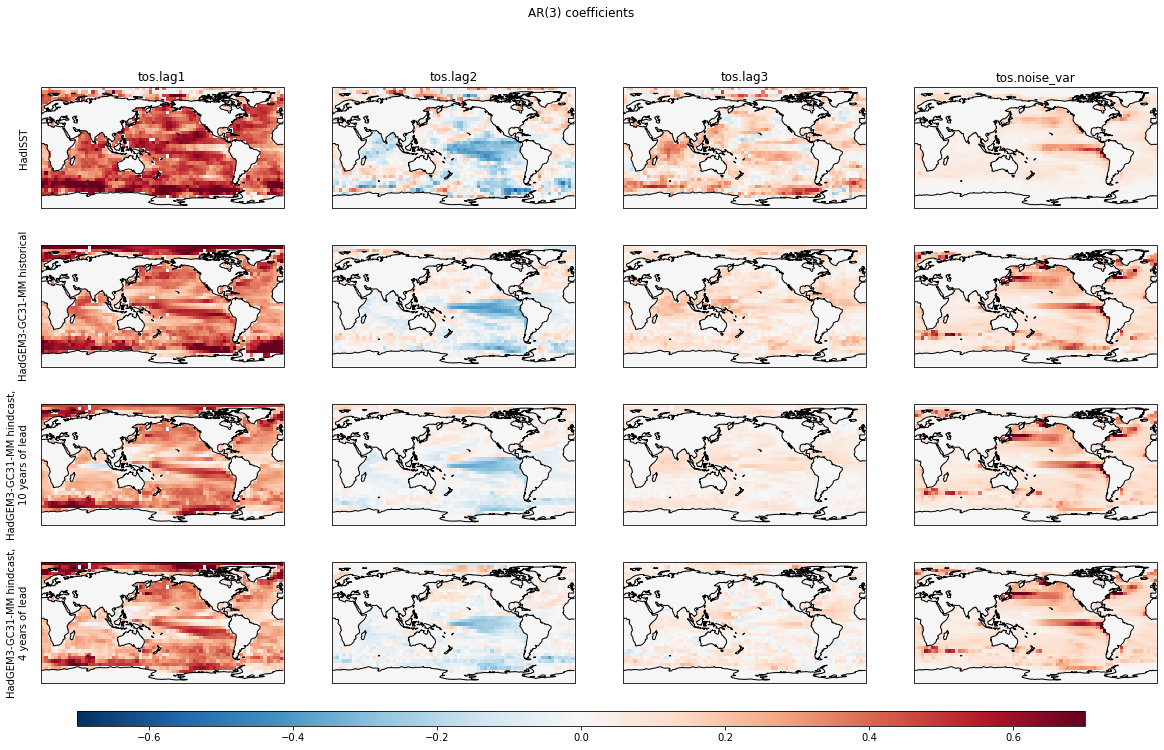

In [149]:
fig = plt.figure(figsize=(5 * (n_lags + 1), 2.6 * len(params)))
axs = fig.subplots(
    n_lags + 1,
    len(params),
    subplot_kw=dict(projection=ccrs.PlateCarree(180), sharex=True, sharey=True),
)
vrange = (-0.7, 0.7)

for idy, (name, ds) in enumerate(params.items()):
    for idx, param in enumerate(ds.params.values):
        ax = axs[idy, idx]
        p = (
            ds[list(ds.data_vars)[0]]
            .sel(params=param)
            .plot(
                ax=ax,
                transform=ccrs.PlateCarree(),
                cmap="RdBu_r",
                add_colorbar=False,
                vmin=vrange[0],
                vmax=vrange[1],
            )
        )

        p.axes.set_global()
        p.axes.coastlines()
        ax.set_title("")
        if idx == 0:
            ax.text(
                -0.05,
                0.5,
                f"{name}",
                va="bottom",
                ha="center",
                rotation="vertical",
                rotation_mode="anchor",
                transform=ax.transAxes,
            )
        if idy == 0:
            ax.set_title(param)

fig.suptitle("AR(3) coefficients")

fig.subplots_adjust(bottom=0.07)
cbar_ax = fig.add_axes([0.15, 0.02, 0.7, 0.02])
_ = fig.colorbar(p, cax=cbar_ax, orientation="horizontal")

# Generate some synthetic hindcasts

#### Generate some inital conditions from the HadISST params

In [79]:
n_samples = 10

inits = ar_model.generate_samples(
    params["HadISST"], n_times=reanalysis.sizes["time"], n_samples=n_samples
)

inits = xr.concat(
    [reanalysis.assign_coords({"time": inits.time, "sample": [-1]}), inits],
    dim="sample",
)

#### Generate hindcasts for each model fit

In [81]:
synthetic = {
    name: ar_model.predict(
        param, inits, n_steps=hindcast.sizes["lead"], n_members=hindcast.sizes["member"]
    )
    for name, param in params.items()
}

# Compare the ACFs to real data

In [115]:
def are_acfs_consistent(baseline, simulation, n_lags, ensemble_mean=True, dim="time"):
    """
    Check whether the baseline ACFs fall within confidence bounds generated
    from multiple samples of the simulated process
    """
    quantile_bounds = (0.025, 0.975)

    if ensemble_mean:
        baseline = baseline.mean("member")
        simulation = simulation.mean("member")

    baseline_acf = stats.acf(baseline, dim=dim, nlags=n_lags)
    simulation_acf = stats.acf(simulation, dim=dim, nlags=n_lags)

    simulation_acf_lower = simulation_acf.quantile(quantile_bounds[0], dim="sample")
    simulation_acf_upper = simulation_acf.quantile(quantile_bounds[1], dim="sample")

    return (
        (baseline_acf >= simulation_acf_lower) & (baseline_acf <= simulation_acf_upper)
    ).all("lag")

#### Compare time-dimension ACFs of the synthetic initial conditions and the reanalysis data. 

In [116]:
consistent_inits = are_acfs_consistent(
    reanalysis, inits, n_lags=n_lags, ensemble_mean=False
)

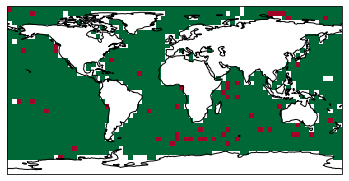

In [131]:
p = (
    consistent_inits["tos"]
    .where(mask)
    .plot(
        subplot_kws=dict(projection=ccrs.PlateCarree()),
        transform=ccrs.PlateCarree(),
        cmap="RdYlGn",
        add_colorbar=False,
    )
)

p.axes.set_global()
_ = p.axes.coastlines()

#### Compare init-averaged, lead-dimension ACFs of the reanalysis-initialised synthetic hindcasts the real hindcasts

In [54]:
hindcast_leads = [1]
synthetic_leads = [1]

In [59]:
consistent_acfs = {}
for name, synth in synthetic.items():
    consistent_acfs[name] = are_acfs_consistent(
        hindcast.sel(lead=hindcast_leads).mean("lead"),
        synth.sel(lead=synthetic_leads).mean("lead"),
        dim="init",
    )

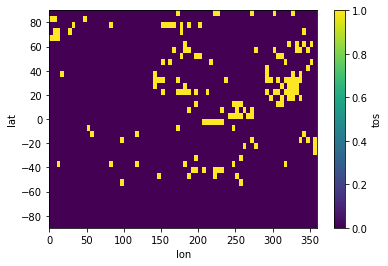

In [62]:
consistent_acfs["HadISST"]["tos"].plot()

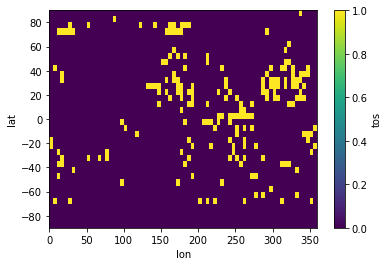

In [64]:
consistent_acfs["HadGEM3-GC31-MM historical"]["tos"].plot()

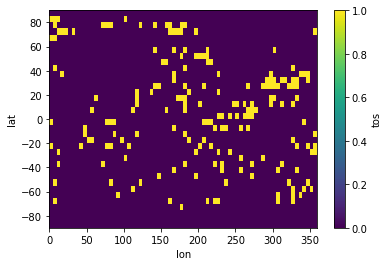

In [65]:
consistent_acfs["HadGEM3-GC31-MM hindcast"]["tos"].plot()